In [1]:
# https://github.com/kuk/log-progress
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

In [2]:
import re
import os

import pandas as pd
import numpy as np
import pickle
from z3 import *

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

from VeriGB import get_gamma_R

pd.set_option('display.max_columns', 500)

np.random.seed(0)

In [3]:
housing_data = pd.read_csv('./Data/kc_house_data.csv')

sqft_cols = [i for i in housing_data.columns if 'sqft' in i]
D = len(sqft_cols)

X = housing_data[sqft_cols]
y = housing_data['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

# In this experiment, we use unscaled data.
# ss = StandardScaler()
# X_train = ss.fit_transform(X_train)
# X_test = ss.transform(X_test)

In [4]:
# Z3 timeout (10mn)
set_option(timeout = 1000 * 60 * 10)

In [ ]:
tree_depth_options = [3,5,8,10]
estimator_options = [50, 100, 200, 300, 400, 500]
number_sampled = 1000
epsilon=160
delta=100000

for max_depth in tree_depth_options:
    for estimators in estimator_options:
        print(f'Testing for estimators={estimators}, max_depth={max_depth}')
        
        gbr = GradientBoostingRegressor(
            max_depth = max_depth,
            learning_rate = 0.1,
            n_estimators = estimators
        )

        gbr.fit(X_train, y_train)
        y_pred = gbr.predict(X_test)

        sampled_indices = np.random.choice(range(len(X_test)), number_sampled, replace=False)
        X_test_trimmed = np.delete(X_test, sampled_indices, axis = 0)
        y_test_trimmed = np.delete(y_test, sampled_indices, axis = 0)

        X_counter = []

        counter_indices = []

        for i, idx in log_progress(enumerate(sampled_indices), every=1, size=number_sampled):
            model_expression, all_reals = get_gamma_R(gbr, X_input=X_test[idx], epsilon=epsilon, delta=delta)
            exec(",".join(list(all_reals)) + " = Reals('" + " ".join(list(all_reals)) + "')")
            gamma_ = eval(re.sub("\s+", '', model_expression))

            s = Solver()
            s.add(gamma_)
            if s.check() == sat: # If there is a counter example
                counter_indices.append(idx)

                # Retrieve all x variables
                X = [0] * D
                for variable in s.model():
                    if str(variable).startswith("x"):
                        X[int(str(variable)[2:])] = float(s.model()[variable].numerator_as_long()) / float(s.model()[variable].denominator_as_long())
                X_counter.append(X)
                
        gbr_counter_1 = GradientBoostingRegressor(max_depth = max_depth, learning_rate = 0.1, n_estimators = estimators)
        gbr_counter_2 = GradientBoostingRegressor(max_depth = max_depth, learning_rate = 0.1, n_estimators = estimators)

        gbr_counter_1.fit(np.append(X_train, X_counter, axis = 0), np.append(y_train, y_test[counter_indices], axis = 0))
        gbr_counter_2.fit(
            np.append(X_train, X_counter, axis = 0),
            np.append(y_train, y_test[counter_indices] + np.where(y_test[counter_indices] < y_pred[counter_indices], epsilon, -epsilon), axis = 0)
        )

        with open(f'CounterExamplesResults/results_estimators={estimators}_depth={max_depth}.pkl', 'wb+') as file:
            results = {
                'counter_indices': counter_indices,
                'X_counter': X_counter,
                'r2_score_1': r2_score(y_test, y_pred),
                'r2_score_2': r2_score(y_test_trimmed, gbr_counter_1.predict(X_test_trimmed)),
                'r2_score_3': r2_score(y_test_trimmed, gbr_counter_2.predict(X_test_trimmed))
            }
            print(results['r2_score_1'], results['r2_score_2'], results['r2_score_3'])
            pickle.dump(results, file)

Testing for estimators=50, max_depth=3


0.6056243087302053 0.594622156696951 0.594755193184815
Testing for estimators=100, max_depth=3


0.610915414792733 0.6073784986286519 0.6096731516194014
Testing for estimators=200, max_depth=3


0.6115858706854267 0.5859496186364428 0.5859081282461414
Testing for estimators=300, max_depth=3


0.605642592843124 0.5931814489169968 0.5919009991911225
Testing for estimators=400, max_depth=3


0.6054302452216702 0.6099067647985303 0.607263089018941
Testing for estimators=500, max_depth=3


0.6001774435503275 0.5856370857053614 0.5803093037486137
Testing for estimators=50, max_depth=5


0.606650703395962 0.6193932510029746 0.6185030722368599
Testing for estimators=100, max_depth=5


0.604735832789852 0.6169546938810007 0.6202388556281118
Testing for estimators=200, max_depth=5


0.6015039380471066 0.6121539068827705 0.6141395321222975
Testing for estimators=300, max_depth=5


0.596464421373037 0.5603417172267079 0.5557404707304813
Testing for estimators=400, max_depth=5


0.5881427445251879 0.5738915934977844 0.5737841039493751
Testing for estimators=500, max_depth=5


0.5853820702898636 0.5808190595133342 0.5871042502556029
Testing for estimators=50, max_depth=8


0.593298319354964 0.5539057636090454 0.5585855691335362
Testing for estimators=100, max_depth=8


0.5943144815156557 0.5892421568939338 0.5843818470468285
Testing for estimators=200, max_depth=8


0.5867870114168994 0.5530721874831913 0.5593912573010813
Testing for estimators=300, max_depth=8


0.5807950234060921 0.6008397826771001 0.6030150342293232
Testing for estimators=400, max_depth=8


# Results

In [14]:
import pickle

tree_depth_options = [3,5,8,10]
estimator_options = [50, 100, 200, 300, 400, 500]
results = dict()

for max_depth in tree_depth_options:
    for estimators in estimator_options:
        try:
            with open(f'CounterExamplesResults/results_estimators={estimators}_depth={max_depth}.pkl', 'rb+') as file:
                results[(max_depth, estimators)] = pickle.load(file)
        except Exception as e:
            print(e)

[Errno 2] No such file or directory: 'CounterExamplesResults/results_estimators=400_depth=8.pkl'
[Errno 2] No such file or directory: 'CounterExamplesResults/results_estimators=500_depth=8.pkl'
[Errno 2] No such file or directory: 'CounterExamplesResults/results_estimators=300_depth=10.pkl'
[Errno 2] No such file or directory: 'CounterExamplesResults/results_estimators=400_depth=10.pkl'
[Errno 2] No such file or directory: 'CounterExamplesResults/results_estimators=500_depth=10.pkl'


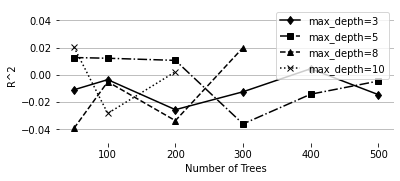

In [15]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

symbol_by_depth = {
    '3':{'marker':'d', 'linestyle':'solid'},
    '5':{'marker':'s', 'linestyle':'dashdot'},
    '8':{'marker':'^', 'linestyle':'dashed'},
    '10':{'marker':'x', 'linestyle':'dotted'}
}

plt.figure(figsize=(6,2.5), facecolor='white')
for max_depth in tree_depth_options:
    lift_values = []
    estimator_values = []
    for estimators in estimator_options:
        try:
            this_results = results[(max_depth, estimators)]
        except:
            continue
            
        lift_values.append(this_results['r2_score_2'] - this_results['r2_score_1'])
        estimator_values.append(estimators)
    plt.plot(
        estimator_values, 
        lift_values, 
        label=f'max_depth={max_depth}', 
        marker=symbol_by_depth[str(max_depth)]['marker'], 
        linestyle=symbol_by_depth[str(max_depth)]['linestyle'], 
        color='black'
    )

plt.ylim(-0.05,0.05)
plt.ylabel(r'R^2')
plt.xlabel('Number of Trees')
plt.legend(loc='best')
plt.grid(True, 'major', 'y')
plt.box(on=None)
plt.show()

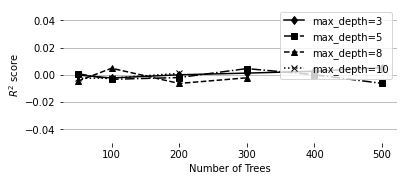

In [16]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

symbol_by_depth = {
    '3':{'marker':'d', 'linestyle':'solid'},
    '5':{'marker':'s', 'linestyle':'dashdot'},
    '8':{'marker':'^', 'linestyle':'dashed'},
    '10':{'marker':'x', 'linestyle':'dotted'}
}

plt.figure(figsize=(6,2.5), facecolor='white')
for max_depth in tree_depth_options:
    lift_values = []
    estimator_values = []
    for estimators in estimator_options:
        try:
            this_results = results[(max_depth, estimators)]
        except:
            continue
            
        lift_values.append(this_results['r2_score_2'] - this_results['r2_score_3'])
        estimator_values.append(estimators)
    plt.plot(
        estimator_values, 
        lift_values, 
        label=f'max_depth={max_depth}', 
        marker=symbol_by_depth[str(max_depth)]['marker'], 
        linestyle=symbol_by_depth[str(max_depth)]['linestyle'], 
        color='black'
    )

plt.ylim(-0.05,0.05)
plt.ylabel(r'$R^2$ score')
plt.xlabel('Number of Trees')
plt.legend(loc='best')
plt.grid(True, 'major', 'y')
plt.box(on=None)
plt.show()